# Variability: combined

This notebook contains all the analyses reported in our paper.

Throughout:

* LHS variables are Z-scores of the mean and std dev of happiness, and also of relaxation and wakefulness.
* We count no more than one response per day per user, chosen at random from that user-day's responses.
* Region dummies are included in all models (including a _missing region_ category, so as not to reduce sample size unduly).
* We use [`hc3` standard errors](https://datacolada.org/99) when possible.

Within these parameters, we estimate the following models:

* Our main spec remains a pooled OLS analysis of weekly values per user, clustering on `user_id`. We draw graphs for this spec only.
* As a robustness-check model, we run `xtfef` on the same set of variables. This adds individual fixed effects while still estimating coefficients on the time-invariant user characteristics (income, kids, etc — these are all effectively time-invariant in _Mappiness_, since we only asked about them once).
* As a further robustness-check model, we run an OLS with only one row per user, which has the mean and std dev across the first 14 valid responses (limiting to 1 per day), as long as those were provided within 28 days.

In [1]:
set more off, permanently
set scheme s1mono


(set more preference recorded)



On the following data cleaning rules:

* under-18s weren't supposed to sign up, over-99s seem more likely an input error than a true age
* the project didn't launch until mid-August 2010, so anything prior is test data
* 2017 + 2018 together comprise 0.8% of the data

In [2]:
use "~/mappiness/krekel/mpns_krekel_2020-01-29.dta", replace
keep if valid_response

drop if age_at_signup < 18 | age_at_signup > 99 | response_td < date("2010-08-14", "YMD") | response_td > date("2016-12-31", "YMD")
format %tdDay_DD_Mon_CCYY response_td



(5,233,285 observations deleted)

(77,706 observations deleted)



In [3]:
capture drop response_year
gen response_year = year(response_td)
tab response_year





response_ye |
         ar |      Freq.     Percent        Cum.
------------+-----------------------------------
       2010 |  1,150,245       37.47       37.47
       2011 |    892,845       29.08       66.55
       2012 |    349,997       11.40       77.95
       2013 |    300,773        9.80       87.75
       2014 |    180,383        5.88       93.63
       2015 |    104,015        3.39       97.02
       2016 |     91,624        2.98      100.00
------------+-----------------------------------
      Total |  3,069,882      100.00


In [4]:
replace work = 8 if work == 4  // work == 4 means 'Other', and it looks better if this is at the end

(59,071 real changes made)


In [5]:
label define work 8 "other", add

In [6]:
capture drop anykids
gen anykids = kids != 0
tab anykids





    anykids |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |  2,235,312       72.81       72.81
          1 |    834,570       27.19      100.00
------------+-----------------------------------
      Total |  3,069,882      100.00


### Limit to one user-response per day

Now, the first thing we do is ensure each user has no more than one daily response, picked at random.

In [7]:
capture drop rnd
set seed 967253  // reproducible
gen rnd = runiform()

capture drop user_day_rnd
bysort user_id response_td (rnd): gen user_day_rnd = _n

In [8]:
%head 25 response_tc user_day_rnd if user_id == 102

,response_tc,user_day_rnd
1723,15aug2010 09:03:22,1
1724,15aug2010 15:28:05,2
1725,16aug2010 08:43:50,1
1726,16aug2010 14:58:45,2
1727,17aug2010 17:17:08,1
1728,17aug2010 11:41:30,2
1729,17aug2010 21:13:36,3
1730,18aug2010 14:27:56,1
1731,18aug2010 10:15:48,2
1732,18aug2010 19:45:50,3


Looks good! So let's keep only #1.

In [9]:
drop if user_day_rnd != 1
drop user_day_rnd


(1,240,976 observations deleted)



### Weekly aggregates

We split the data into weeks by identifying, for each response time, the date of the Monday of the week in which it falls.

In [10]:
capture drop response_dow
gen response_dow = dow(response_td)  // dow() maps Sunday - Saturday to 0 – 6

capture drop response_monday
gen response_monday = response_td - cond(response_dow == 0, 6, response_dow - 1)

format %tdDay_DD_Mon_CCYY response_monday

In [11]:
%head response_td response_monday

,response_td,response_monday
1,Sun 15 Aug 2010,Mon 09 Aug 2010
2,Tue 17 Aug 2010,Mon 16 Aug 2010
3,Wed 25 Aug 2010,Mon 23 Aug 2010
4,Mon 30 Aug 2010,Mon 30 Aug 2010
5,Thu 02 Sep 2010,Mon 30 Aug 2010
6,Thu 16 Sep 2010,Mon 13 Sep 2010
7,Fri 17 Sep 2010,Mon 13 Sep 2010
8,Sat 14 Aug 2010,Mon 09 Aug 2010
9,Sun 15 Aug 2010,Mon 09 Aug 2010
10,Mon 16 Aug 2010,Mon 16 Aug 2010


Now we calculate weekly count and variance by user × week:

In [12]:
sort user_id response_monday

capture drop weekly_count
by user_id response_monday: egen weekly_count = count(response_id)

foreach feeling in hpy rlx awk {
  capture drop `feeling'_weekly_mean
  capture drop `feeling'_weekly_sd
  capture drop `feeling'_weekly_median
  capture drop `feeling'_weekly_skew
  
  by user_id response_monday: egen `feeling'_weekly_mean = mean(feel_`feeling')  // no missing values
  by user_id response_monday: egen `feeling'_weekly_sd   = sd(feel_`feeling')    // missing values when weekly N < 2
  
  // https://www.statalist.org/forums/forum/general-stata-discussion/general/1395658-computation-time-of-egen-function-skew
  by user_id response_monday: egen `feeling'_weekly_median = median(feel_`feeling')
  gen `feeling'_weekly_skew = (`feeling'_weekly_mean - `feeling'_weekly_median) / `feeling'_weekly_sd if weekly_count > 2  // missing values when weekly N < 3
}





(68647 missing values generated)
(195,297 missing values generated)
(68647 missing values generated)
(192,906 missing values generated)
(68647 missing values generated)
(195,897 missing values generated)


In [13]:
%head 25 ///
  user_id response_td response_monday feel_hpy weekly_count ///
  hpy_weekly_mean hpy_weekly_sd hpy_weekly_median hpy_weekly_skew

,user_id,response_td,response_monday,feel_hpy,weekly_count,hpy_weekly_mean,hpy_weekly_sd,hpy_weekly_median,hpy_weekly_skew
1,33,Sun 15 Aug 2010,Mon 09 Aug 2010,62.449802,1,62.449802,.,62.449802,.
2,33,Tue 17 Aug 2010,Mon 16 Aug 2010,27.509998,1,27.509998,.,27.509998,.
3,33,Wed 25 Aug 2010,Mon 23 Aug 2010,39.959801,1,39.959801,.,39.959801,.
4,33,Mon 30 Aug 2010,Mon 30 Aug 2010,6.6265097,2,20.281105,19.310513,20.281105,.
5,33,Thu 02 Sep 2010,Mon 30 Aug 2010,33.935699,2,20.281105,19.310513,20.281105,.
6,33,Thu 16 Sep 2010,Mon 13 Sep 2010,52.811199,2,50,3.975636,50,.
7,33,Fri 17 Sep 2010,Mon 13 Sep 2010,47.188801,2,50,3.975636,50,.
8,43,Sat 14 Aug 2010,Mon 09 Aug 2010,91.767105,2,91.566299,.2839767,91.566299,.
9,43,Sun 15 Aug 2010,Mon 09 Aug 2010,91.365501,2,91.566299,.2839767,91.566299,.
10,43,Mon 16 Aug 2010,Mon 16 Aug 2010,80.120499,5,84.698776,6.4980702,87.349403,-.4079099


Let's look at the distribution of the variances. For this, we'll want a way to count each user only once a week (the full dataset has one row per response, so if someone responded 10 times in a week their variance value for that week will be repeated 10 times).

So we'll identify each user's first response each week (as `userweekseq == 1`). And because it's likely to be useful later on, we'll start by also identifying each user's first *ever* response (as `userseq == 1`).

In [14]:
sort user_id response_id

capture drop userseq
by user_id (response_id): egen userseq = seq()

count if userseq == 1





  50,637


(That's the number of unique users we have).

In [15]:
sort user_id response_monday response_id

capture drop userweekseq
by user_id response_monday (response_id): egen userweekseq = seq()

count if userweekseq == 1





  431,659


(And that's unique user-weeks).

In [16]:
%head 27 user_id response_td response_monday userseq userweekseq weekly_count if user_id == 290

,user_id,response_td,response_monday,userseq,userweekseq,weekly_count
11922,290,Sat 14 Aug 2010,Mon 09 Aug 2010,1,1,2
11923,290,Sun 15 Aug 2010,Mon 09 Aug 2010,2,2,2
11924,290,Mon 16 Aug 2010,Mon 16 Aug 2010,3,1,6
11925,290,Tue 17 Aug 2010,Mon 16 Aug 2010,4,2,6
11926,290,Wed 18 Aug 2010,Mon 16 Aug 2010,5,3,6
11927,290,Thu 19 Aug 2010,Mon 16 Aug 2010,6,4,6
11928,290,Fri 20 Aug 2010,Mon 16 Aug 2010,7,5,6
11929,290,Sat 21 Aug 2010,Mon 16 Aug 2010,8,6,6
11930,290,Mon 23 Aug 2010,Mon 23 Aug 2010,9,1,6
11931,290,Tue 24 Aug 2010,Mon 23 Aug 2010,10,2,6


(OK, that seems to work nicely).

In [17]:
tab weekly_count if userweekseq == 1


weekly_coun |
          t |      Freq.     Percent        Cum.
------------+-----------------------------------
          1 |     68,647       15.90       15.90
          2 |     52,916       12.26       28.16
          3 |     48,996       11.35       39.51
          4 |     49,269       11.41       50.93
          5 |     53,867       12.48       63.41
          6 |     64,720       14.99       78.40
          7 |     93,244       21.60      100.00
------------+-----------------------------------
      Total |    431,659      100.00


In [18]:
%set graph_width 1350

In [19]:
%set graph_height 300

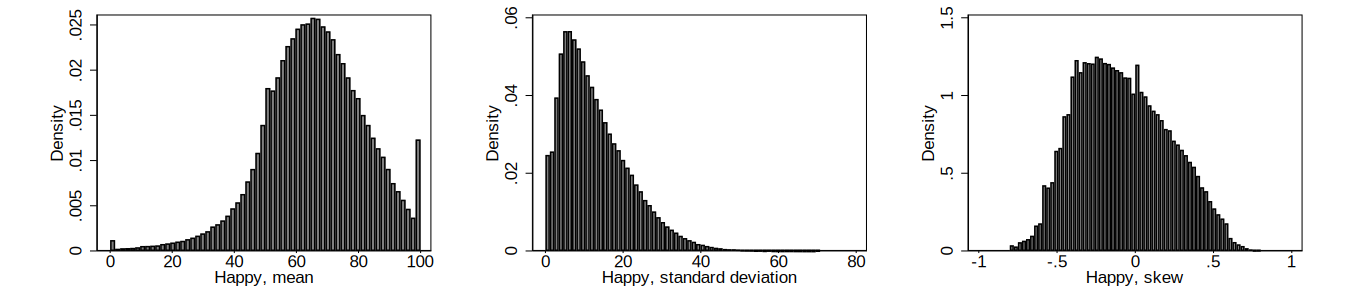

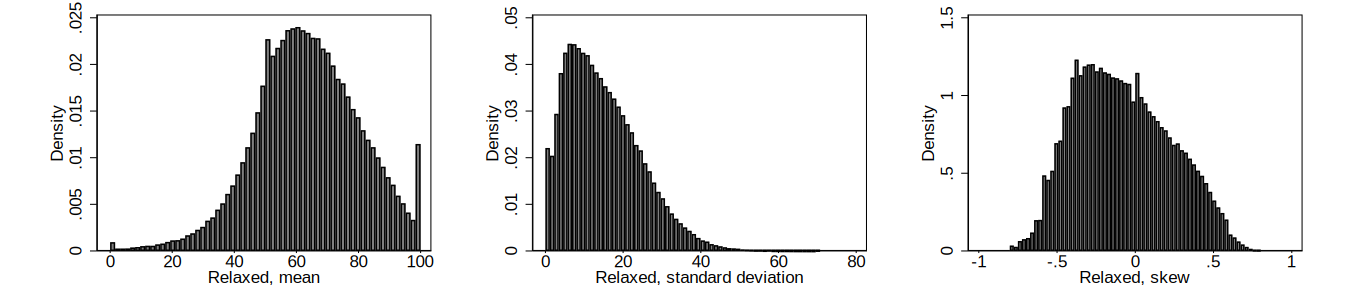

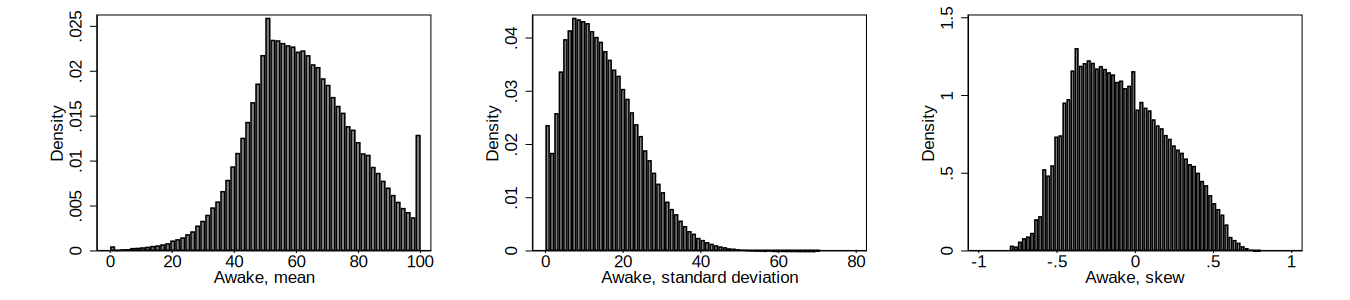

In [20]:
foreach feeling in hpy rlx awk {
  foreach param in mean sd skew {
    local feelingname = cond("`feeling'" == "hpy", "Happy", cond("`feeling'" == "rlx", "Relaxed", "Awake"))
    local paramname = cond("`param'" == "mean", "mean", cond("`param'" == "sd", "standard deviation", "skew"))
    
    quietly hist `feeling'_weekly_`param', name(tmpgph_`param', replace) ///
      scale(0.667) xscale(titlegap(7)) xlabel(, labgap(7)) xtitle("`feelingname', `paramname'")
  }
  graph combine tmpgph_mean tmpgph_sd tmpgph_skew, cols(3)
}

### Missing home locations

In [21]:
count if !missing(home_nspd_go_region)
count if missing(home_nspd_go_region)


  1,290,092

  538,814


There are quite a lot of missing regions (for people who never answered at home, or weren't in the UK), so let's create a non-missing 'missing' category ...

In [22]:
replace home_nspd_go_region = 99 if missing(home_nspd_go_region)  // existing range is 1 - 12
tab home_nspd_go_region, missing


(538,814 real changes made)


home_nspd_g |
   o_region |      Freq.     Percent        Cum.
------------+-----------------------------------
  E12000001 |     35,785        1.96        1.96
  E12000002 |    112,309        6.14        8.10
  E12000003 |     85,740        4.69       12.79
  E12000004 |     79,669        4.36       17.14
  E12000005 |     80,833        4.42       21.56
  E12000006 |    105,560        5.77       27.33
  E12000007 |    339,280       18.55       45.88
  E12000008 |    207,915       11.37       57.25
  E12000009 |    101,718        5.56       62.81
  N99999999 |     13,805        0.75       63.57
  S99999999 |     80,436        4.40       67.97
  W99999999 |     47,042        2.57       70.54
         99 |    538,814       29.46      100.00
------------+-----------------------------------
      Total |  1,828,906      100.00


### Z-scores

* We limit the regression on the mean to the same sample as the regression on the SD (this excludes any user-weeks with only one response, where there is no SD).
* We standardize the variables also using only these same rows that actually make it into the regression — i.e.  excluding single-response weeks and any responses with missing data (such as home region).

In [25]:
local userrhsvars ///
  lnhhinc b3.work b1.male#b0.anykids b4.mrg b1.adults age_at_signup c.age_at_signup#c.age_at_signup b5.health b7.home_nspd_go_region

local rhsvars ///
  `userrhsvars' ///
  b2010.response_year response_seq c.response_seq#c.response_seq ///
  b2.weekly_count

quietly reg hpy_weekly_sd `rhsvars' if userweekseq == 1

capture drop varsample
gen varsample = e(sample)

In [23]:
%set graph_width 1350

In [24]:
%set graph_height 300


(1490459 missing values generated)
(1490459 missing values generated)
(1542959 missing values generated)


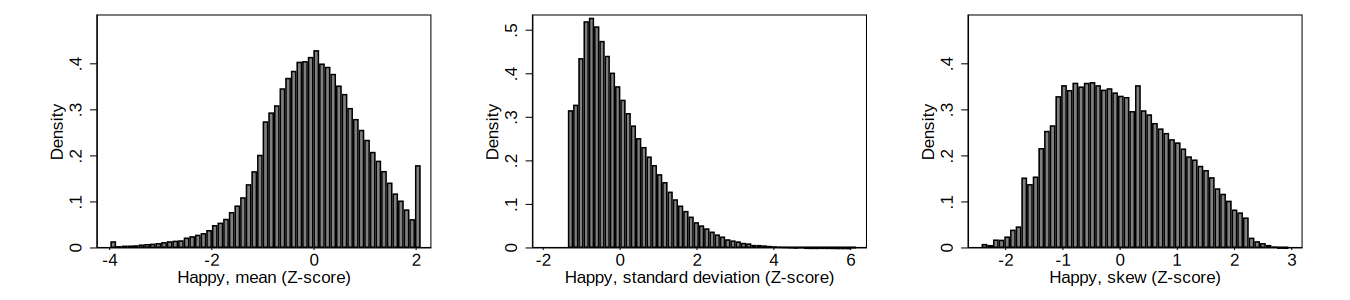

(1490459 missing values generated)
(1490459 missing values generated)
(1542577 missing values generated)


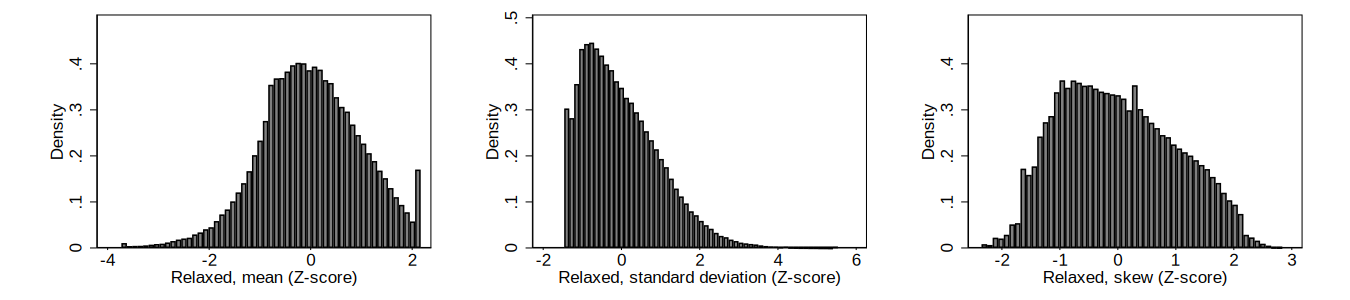

(1490459 missing values generated)
(1490459 missing values generated)
(1543096 missing values generated)


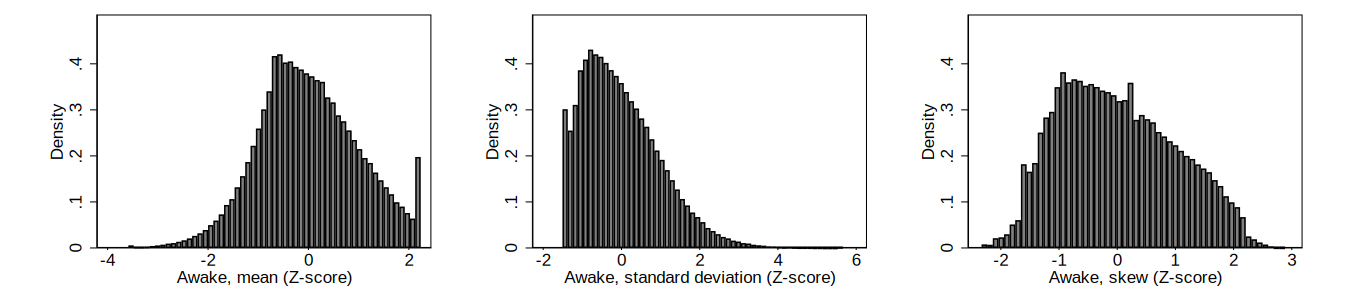

In [26]:
foreach feeling in hpy rlx awk {
  foreach param in mean sd skew {
    capture drop z_`feeling'_weekly_`param'
    egen z_`feeling'_weekly_`param' = std(`feeling'_weekly_`param') if varsample
    
    local feelingname = cond("`feeling'" == "hpy", "Happy", cond("`feeling'" == "rlx", "Relaxed", "Awake"))
    local paramname = cond("`param'" == "mean", "mean", cond("`param'" == "sd", "standard deviation", "skew"))
    
    quietly hist z_`feeling'_weekly_`param', name(tmpgph_`param', replace) ///
      scale(0.667) xscale(titlegap(8)) yscale(range(0 .5)) xlabel(, labgap(8)) xtitle("`feelingname', `paramname' (Z-score)")
  }
  graph combine tmpgph_mean tmpgph_sd tmpgph_skew, cols(3)
}

## Main spec OLS regressions

In [27]:
foreach feeling in hpy rlx awk {
  foreach param in mean sd skew {
    
    local mean_controls = cond("`param'" == "mean", "", ///
      "z_`feeling'_weekly_mean c.z_`feeling'_weekly_mean#c.z_`feeling'_weekly_mean")
    
    reg z_`feeling'_weekly_`param' `rhsvars' `mean_controls' if varsample, vce(cluster user_id)
    
    test 0.male#0b.anykids = 0.male#1.anykids  // woman with kids vs woman without kids
    test 0.male#1.anykids = 1b.male#1.anykids  // man with kids vs woman with kids
    
    estimates store reg_`feeling'_`param'
    parmest, frame(reg_est_`feeling'_`param', replace)
  }
}



Linear regression                               Number of obs     =    338,447
                                                F(48, 41022)      =      20.17
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0512
                                                Root MSE          =     .97414

                            (Std. Err. adjusted for 41,023 clusters in user_id)
-------------------------------------------------------------------------------
              |               Robust
z_hpy_weekl~n |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
--------------+----------------------------------------------------------------
      lnhhinc |   .0461673   .0143189     3.22   0.001      .018102    .0742327
              |
         work |
        care  |   .0507389   .0636978     0.80   0.426    -.0741101    .1755879
         edu  |   .0165874   .0275053     0.60   0.54

Note that we can't specify both `cluster` and `hc3` for the standard errors simultaneously, and clustering seems much more critical here.

### Tables

In [28]:
%html

#delimit ;
foreach feeling in hpy rlx awk {;
  estout reg_`feeling'_mean reg_`feeling'_sd  reg_`feeling'_skew, 
    style(html) prehead("<h4>`feeling'</h4><table>") postfoot("</table><hr>")
    cells((b(fmt(%20.3g)) ci(par fmt(%20.3g))))
    stats(N N_clust r2 r2_a F df_m df_r, 
      fmt(0       0  3    3 3    0    0) 
      labels("N (user-weeks)" "Users" "R<sup>2</sup>" "Adjusted R<sup>2</sup>")
    )
    legend
    mlabels("<b>Mean</b>" "<b>Std dev</b>"  "<b>Skew</b>")
    collabels("<i>Coeff</i>" "<i>[95% CI]</i>")
    drop(
      // nobaselevels drops base levels in interactions, so we resort to dropping them manually instead
      3.work 
      1.male#0.anykids
      4.mrg
      1.adults
      5.health
      7.home_nspd_go_region
      2010.response_year
      2.weekly_count
    )
    refcat(
      1.work "<b>Employment status</b><br>Base: employed or self-employed"
      0.male#0.anykids "<b>Gender × children in household</b><br>Base: male, no children"
      1.mrg "<b>Marital status</b><br>Base: single"
      2.adults "<b>Adults in the household</b><br>Base: 1"
      age_at_signup "<b>Age at signup</b>"
      1.health "<b>Self-reported health</b><br>Base: excellent"
      1.home_nspd_go_region "<b>Home region</b><br>Base: London"
      2011.response_year "<b>Year (at first response of week)</b><br>Base: 2010"
      response_seq "<b>Prior responses</b>"
      3.weekly_count "<b>Week's responses</b><br>Base: 2"
      z_hpy_weekly_mean "<b>Mean happiness</b>"
      z_rlx_weekly_mean "<b>Mean relaxation</b>"
      z_awk_weekly_mean "<b>Mean wakefulness</b>"
      _cons ""
    , nolabel)
    varlabels(
      1.work "Looking after family or home"
      2.work "In full-time education"
      5.work "Retired"
      6.work "Long-term sick or disabled"
      7.work "Unemployed and seeking work"
      8.work "Other"
      lnhhinc "Log of household income"
      0.male#0.anykids "Female, no children"
      0.male#1.anykids "Female, with children"
      1.male#1.anykids "Male, with children"
      1.mrg "Divorced"
      2.mrg "Married"
      3.mrg "Separated"
      5.mrg "Widowed"
      2.adults "2"
      3.adults "3"
      4.adults "4 or more"
      age_at_signup "Age"
      c.age_at_signup#c.age_at_signup "Age squared"
      1.health "Poor"
      2.health "Fair"
      3.health "Good"
      4.health "Very good"
      1.home_nspd_go_region "North East" // E12000001
      2.home_nspd_go_region  "North West"  // E12000002 
      3.home_nspd_go_region  "Yorkshire and The Humber"  // E12000003 
      4.home_nspd_go_region  "East Midlands"  // E12000004 
      5.home_nspd_go_region  "West Midlands"  // E12000005 
      6.home_nspd_go_region  "East of England"  // E12000006 
      8.home_nspd_go_region  "South East"  // E12000008 
      9.home_nspd_go_region  "South West"  // E12000009 
      10.home_nspd_go_region "Northern Ireland"  // N99999999  
      11.home_nspd_go_region "Scotland"  // S99999999  
      12.home_nspd_go_region "Wales"  // W99999999
      99.home_nspd_go_region "Unknown/non-UK"
      2011.response_year "2011"
      2012.response_year "2012"
      2013.response_year "2013"
      2014.response_year "2014"
      2015.response_year "2015"
      2016.response_year "2016"
      response_seq "Count"
      c.response_seq#c.response_seq "Count squared"
      3.weekly_count "3"
      4.weekly_count "4"
      5.weekly_count "5"
      6.weekly_count "6"
      7.weekly_count "7"
      z_`feeling'_weekly_mean "Standardized mean"
      c.z_`feeling'_weekly_mean#c.z_`feeling'_weekly_mean "Standardized mean squared"
      _cons "Constant"
    );
};
#delimit cr

,Mean,,Std dev,,Skew,
,Coeff,[95% CI],Coeff,[95% CI],Coeff,[95% CI]
Log of household income,.0462,"[.0181,.0742]",-.0208,"[-.0359,-.00579]",.00178,"[-.00655,.0101]"
Employment statusBase: employed or self-employed,,,,,,
Looking after family or home,.0507,"[-.0741,.176]",-.065,"[-.139,.00849]",-.0171,"[-.0635,.0294]"
In full-time education,.0166,"[-.0373,.0705]",-.0963,"[-.135,-.0573]",.0221,"[.00211,.042]"
Retired,.0122,"[-.385,.41]",-.16,"[-.276,-.0435]",.0199,"[-.0549,.0948]"
Long-term sick or disabled,-.214,"[-.365,-.0626]",-.11,"[-.212,-.00736]",-.0235,"[-.074,.027]"
Unemployed and seeking work,-.0978,"[-.18,-.0154]",-.062,"[-.119,-.00483]",-.00614,"[-.036,.0237]"
Other,-.0424,"[-.15,.0652]",-.0756,"[-.151,-.000327]",.00617,"[-.0328,.0451]"
"Gender × children in householdBase: male, no children",,,,,,


### Charts (happiness only)

In [29]:
%set graph_width 720

In [30]:
%set graph_height 1080

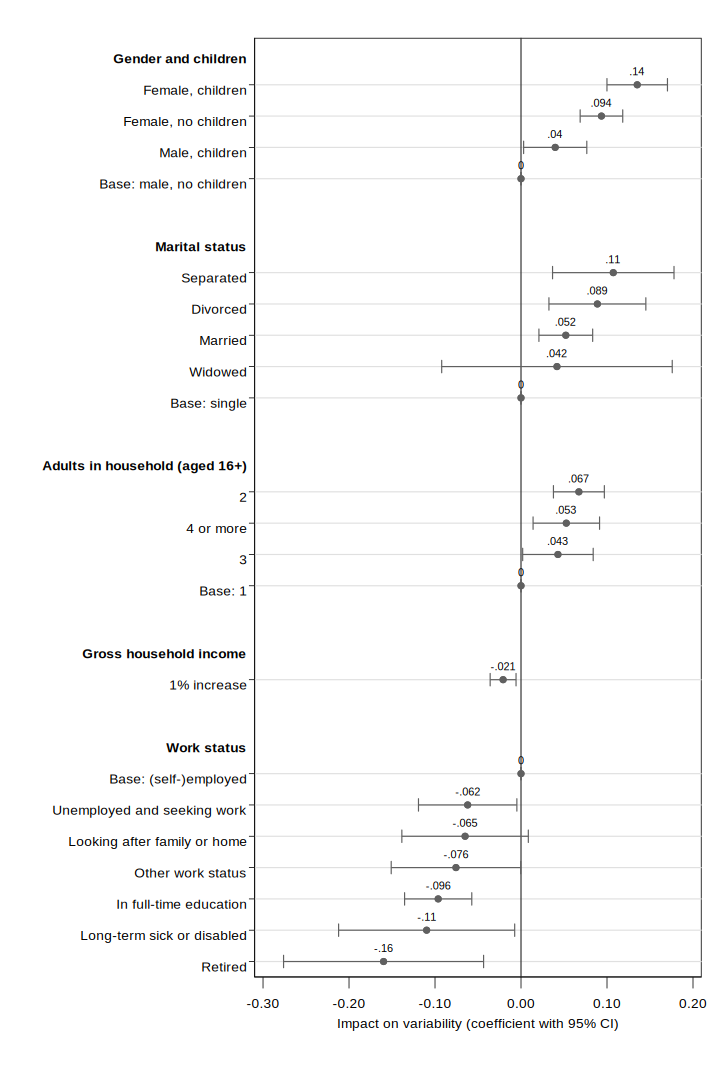

In [31]:
#delimit ;

coefplot (reg_hpy_sd),
keep(
  1.male#0.anykids 0.male#1.anykids 0.male#0.anykids 1.male#1.anykids
  1.mrg 2.mrg 3.mrg 5.mrg 4.mrg
  1.adults 2.adults 3.adults 4.adults 
  1.work 7.work 2.work 5.work 6.work 8.work 3.work
  lnhhinc
)
headings(
  0.male#1.anykids = "{bf:Gender and children}"
  3.mrg = "{bf:Marital status}"
  2.adults = "{bf:Adults in household (aged 16+)}"
  lnhhinc = "{bf:Gross household income}"
  3.work = "{bf:Work status}"
)
order(
  0.male#1.anykids 0.male#0.anykids 1.male#1.anykids 1.male#0.anykids
  3.mrg 1.mrg 2.mrg 5.mrg 4.mrg
  2.adults 4.adults 3.adults 1.adults
  lnhhinc
  3.work 7.work 1.work 8.work 2.work 6.work 5.work 
)
coeflabels(
  lnhhinc = "1% increase"
  1.work = "Looking after family or home"
  2.work = "In full-time education"
  3.work = "Base: (self-)employed"
  5.work = "Retired"
  6.work = "Long-term sick or disabled"
  7.work = "Unemployed and seeking work"
  8.work = "Other work status"
  0.male#0.anykids = "Female, no children"
  0.male#1.anykids = "Female, children"
  1.male#1.anykids = "Male, children"
  1.male#0.anykids = "Base: male, no children"
  1.adults = "Base: 1"
  2.adults = "2"
  3.adults = "3"
  4.adults = "4 or more"
  1.mrg = "Divorced"
  2.mrg = "Married"
  3.mrg = "Separated"
  4.mrg = "Base: single"
  5.mrg = "Widowed"
  1.health = "Poor health"
  2.health = "Fair health"
  3.health = "Good health"
  4.health = "Very good health"
)
baselevels
// recast(bar)
ciopts(recast(rcap))
// grid(within)
xline(0)
xtitle("Impact on variability (coefficient with 95% CI)") 
mlabel(string(@b, "%9.2g")) 
format(%9.2f) mlabposition(12) mlabgap(0.4)
scale(.75)
nolabel
xlabel(, labgap(0)) xscale(titlegap(-1))
;

#delimit cr

We link the frames for the mean and SD results in order to chart them together. Note that we expect 2 unmatched observations: these are the mean control variables in the SD regression only.

In [32]:
frame reg_est_hpy_sd {  
  capture drop reg_est_hpy_mean
  frlink 1:1 parm, frame(reg_est_hpy_mean)
  
  rename estimate sd_estimate
  frget estimate, from(reg_est_hpy_mean) prefix(mean_)
}


  (2 observations in frame reg_est_hpy_sd unmatched)
(2 missing values generated)
  (1 variable copied from linked frame)


#### Categorical: mean vs SD

Let's plot the coefficients on the mean against the coefficients on the standard deviation for the catgeorical dummy variables.

In [33]:
%set graph_width 750

In [34]:
%set graph_height 750


(59 missing values generated)
variable lbl was str1 now str28
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)


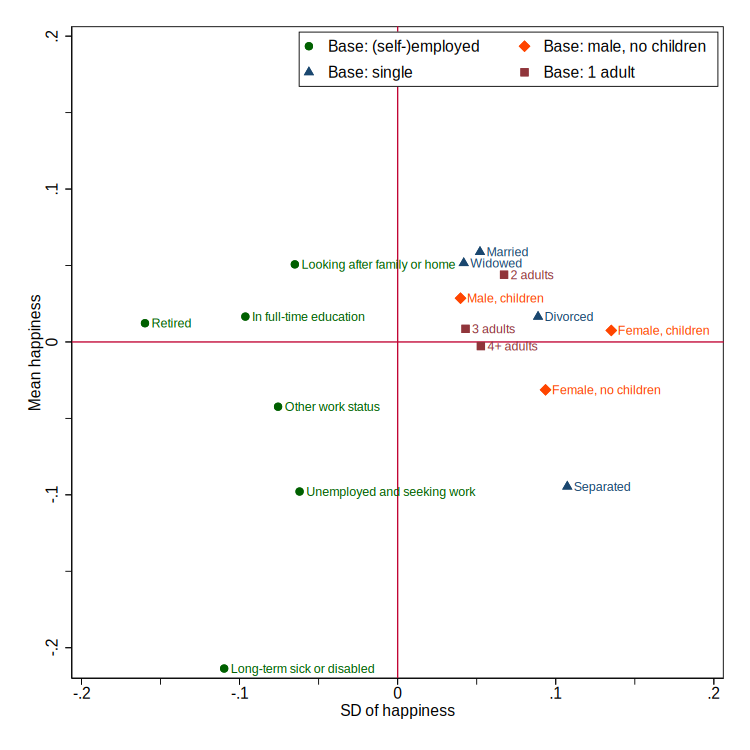

In [35]:
frame reg_est_hpy_sd { 
  capture drop lbl
  gen lbl = ""
  replace lbl = "Looking after family or home" if parm == "1.work"
  replace lbl = "In full-time education" if parm == "2.work"
  replace lbl = "Retired" if parm == "5.work"
  replace lbl = "Long-term sick or disabled" if parm == "6.work"
  replace lbl = "Unemployed and seeking work" if parm == "7.work"
  replace lbl = "Other work status" if parm == "8.work"
  replace lbl = "Female, no children" if parm == "0.male#0b.anykids"
  replace lbl = "Female, children" if parm == "0.male#1.anykids"
  replace lbl = "Male, children" if parm == "1b.male#1.anykids"
  replace lbl = "2 adults" if parm == "2.adults"
  replace lbl = "3 adults" if parm == "3.adults"
  replace lbl = "4+ adults" if parm == "4.adults"
  replace lbl = "Divorced" if parm == "1.mrg"
  replace lbl = "Married" if parm == "2.mrg"
  replace lbl = "Separated" if parm == "3.mrg"
  replace lbl = "Widowed" if parm == "5.mrg"
  replace lbl = "Poor health" if parm == "1.health"
  replace lbl = "Fair health" if parm == "2.health"
  replace lbl = "Good health" if parm == "3.health"
  replace lbl = "Very good health" if parm == "4.health"
  
  set scheme s1color
  
  #delimit ;
  graph twoway ///
    (scatter mean_estimate sd_estimate if lbl != "" & strpos(parm, "work"), mlabel(lbl) msymbol(O))
    (scatter mean_estimate sd_estimate if lbl != "" & strpos(parm, "anykids"), mlabel(lbl) msymbol(D))
    (scatter mean_estimate sd_estimate if lbl != "" & strpos(parm, "mrg"), mlabel(lbl) msymbol(T))
    (scatter mean_estimate sd_estimate if lbl != "" & strpos(parm, "adults"), mlabel(lbl) msymbol(S))
    , xsize(5) ysize(5) scale(0.6) yline(0) xline(0) ///
      xscale(range(-.2 .2)) xlabel(-.2(.1).2) xtick(#8) yscale(range(-.2 .2)) ylabel(-.2(.1).2) ytick(#8)
    ytitle("Mean happiness") xtitle("SD of happiness")
    legend(
      label(1 "Base: (self-)employed")
      label(2 "Base: male, no children")
      label(3 "Base: single")
      label(4 "Base: 1 adult")
      position(0) bplacement(neast)
    )
  ;
  #delimit cr
  
  set scheme s1mono
}

Note that we're omitting health effects from this chart. That's because the magnitude of the negative impact of poor health on mean happiness wrecks the Y scale and causes everything else to cluster in the middle. We can perhaps also argue for excluding those results from the chart on the grounds that the health variable is subjective, unlike the rest.

#### Age

What about age effects? Let's draw those quadratics.

In [36]:
%set graph_width 900

In [37]:
%set graph_height 300


(results reg_hpy_mean are active now)


(results reg_hpy_sd are active now)


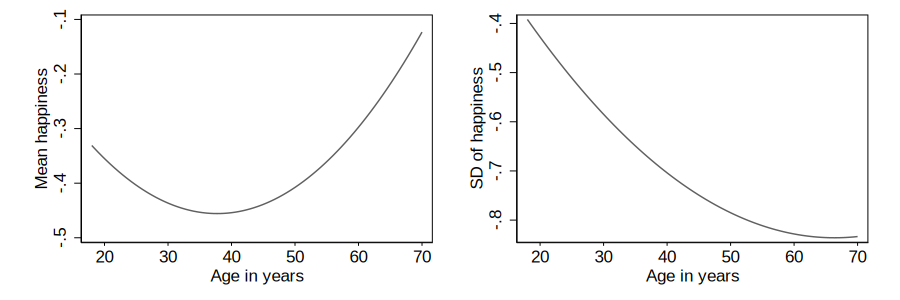

In [38]:
estimates restore reg_hpy_mean
quietly twoway function _b[age_at_signup] * x + _b[c.age_at_signup#c.age_at_signup] * x^2 ///
, range(18 70) xtitle(Age in years) ytitle(Mean happiness) name(age_hpy_mean, replace) xscale(titlegap(5)) xlabel(, labgap(5))

estimates restore reg_hpy_sd
quietly twoway function _b[age_at_signup] * x + _b[c.age_at_signup#c.age_at_signup] * x^2 ///
, range(18 70) xtitle(Age in years) ytitle(SD of happiness) name(age_hpy_sd, replace) xscale(titlegap(5)) xlabel(, labgap(5))

graph combine age_hpy_mean age_hpy_sd, cols(2)

Interestingly, we get the standard U-shape in age for mean happiness, but for the SD we essentially get declining SD with age (hardly anybody in our sample is older than the bottom of the curve here).

In [39]:
local sd_nadir_age = -_b[age_at_signup] / (2 * _b[c.age_at_signup#c.age_at_signup])
disp "Age at SD nadir: `sd_nadir_age'"
count if varsample & age_at_signup > `sd_nadir_age'
count if varsample & age_at_signup <= `sd_nadir_age'



Age at SD nadir: 66.38829144716638

  1,200

  337,247


(Over-66s are less than 0.4% of the sample)

#### Income

Let's also plot the implied changes in happiness mean and SD over the range of income bracket midpoints in the data.


(results reg_hpy_mean are active now)


(results reg_hpy_sd are active now)


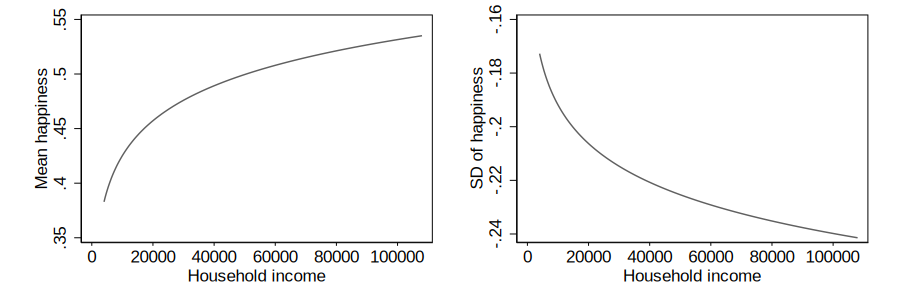

In [40]:
estimates restore reg_hpy_mean
quietly twoway function _b[lnhhinc] * ln(x) ///
, range(4000 108000) xtitle(Household income) ytitle(Mean happiness) name(age_hpy_mean, replace) xscale(titlegap(5)) xlabel(, labgap(5))

estimates restore reg_hpy_sd
quietly twoway function _b[lnhhinc] * ln(x) ///
, range(4000 108000) xtitle(Household income) ytitle(SD of happiness) name(age_hpy_sd, replace) xscale(titlegap(5)) xlabel(, labgap(5))

graph combine age_hpy_mean age_hpy_sd, cols(2)

I suppose it's unclear  whether a log specification is the right one for the SD regression, but consistency with the mean regression (and the standard literature) seems a reasonably good justification.

#### Happiness mean

In [41]:
%set graph_width 450

In [42]:
%set graph_height 300

In [43]:
summ z_hpy_weekly_mean, detail


          Standardized values of (hpy_weekly_mean) 
-------------------------------------------------------------
      Percentiles      Smallest
 1%     -2.82187      -3.984113
 5%    -1.655562      -3.984113
10%    -1.196352      -3.984113       Obs             338,447
25%    -.6233587      -3.984113       Sum of Wgt.     338,447

50%      .012913                      Mean          -9.66e-10
                        Largest       Std. Dev.             1
75%     .6750216       2.087188
90%     1.284996       2.087188       Variance              1
95%     1.622175       2.087188       Skewness      -.3829025
99%     2.087188       2.087188       Kurtosis        3.59175









(results reg_hpy_sd are active now)


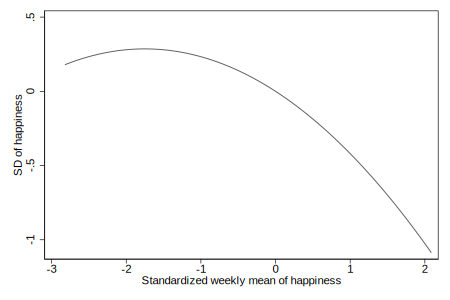

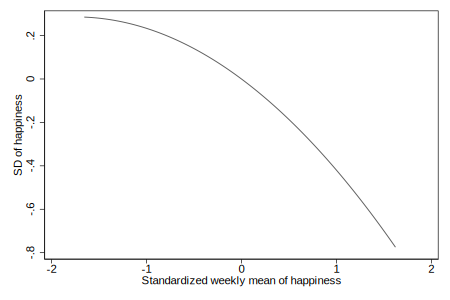

In [44]:
local z_hpy_weekly_mean_p5 = r(p5)
local z_hpy_weekly_mean_p95 = r(p95)
local z_hpy_weekly_mean_p1 = r(p1)
local z_hpy_weekly_mean_p99 = r(p99)
local z_hpy_weekly_mean_min = r(p1)
local z_hpy_weekly_mean_max = r(max)

estimates restore reg_hpy_sd

twoway function _b[z_hpy_weekly_mean] * x + _b[c.z_hpy_weekly_mean#c.z_hpy_weekly_mean] * x^2 ///
, range(`z_hpy_weekly_mean_min' `z_hpy_weekly_mean_max') xtitle(Standardized weekly mean of happiness) ytitle(SD of happiness) ///
  name(mean_vs_sd_curve, replace)

twoway function _b[z_hpy_weekly_mean] * x + _b[c.z_hpy_weekly_mean#c.z_hpy_weekly_mean] * x^2 ///
, range(`z_hpy_weekly_mean_p5' `z_hpy_weekly_mean_p95') xtitle(Standardized weekly mean of happiness) ytitle(SD of happiness) ///
  name(mean_vs_sd_curve, replace)

## Life satisfaction regression

Let's reassure ourselves that the LS results look normal.

We start by picking one response per user that's included in the main spec regressions.

In [45]:
sort user_id response_id

capture drop varsampleseq
by user_id (response_id): egen varsampleseq = seq() if varsample

count if varsampleseq == 1




(1490459 missing values generated)

  41,023


Now to run the regression:

In [46]:
reg ls `userrhsvars' if varsampleseq == 1, vce(hc3)

test 0.male#0b.anykids = 0.male#1.anykids  // woman with kids vs woman without kids
test 0.male#1.anykids = 1b.male#1.anykids  // man with kids vs woman with kids



Linear regression                               Number of obs     =     41,023
                                                F(35, 40987)      =     198.90
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1642
                                                Root MSE          =     1.4732

-------------------------------------------------------------------------------
              |             Robust HC3
           ls |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
--------------+----------------------------------------------------------------
      lnhhinc |   .1661167   .0105981    15.67   0.000     .1453443    .1868892
              |
         work |
        care  |  -.0378182   .0586566    -0.64   0.519    -.1527863      .07715
         edu  |   .1999446   .0266283     7.51   0.000     .1477526    .2521366
         ret  |   .3393267   .1016763     3.34   0.

### Table

In [47]:
%html
#delimit ;

estout, 
  style(html) prehead("<table>") postfoot("</table>")
  cells((b(fmt(%20.3g)) ci(par fmt(%20.3g))))
  starlevels(+ 0.1 * 0.05 ** 0.01 *** 0.001)
  stats(N r2 r2_a F df_m df_r, 
    fmt(0  3    3 3    0    0) 
    labels("N" "R<sup>2</sup>" "Adjusted R<sup>2</sup>")
  )
  legend
  mlabels("<b>Life satisfaction</b>")
  collabels("<i>Coeff</i>" "<i>[95% CI]</i>")
  // nobaselevels
  drop(
    // nobaselevels drops base levels in interactions, so we resort to dropping them manually instead
    3.work 
    1.male#0.anykids
    4.mrg
    1.adults
    5.health
    7.home_nspd_go_region
  )
  refcat(
    1.work "<b>Employment status</b><br>Base: employed or self-employed"
    0.male#0.anykids "<b>Gender × children in household</b><br>Base: male, no children"
    1.mrg "<b>Marital status</b><br>Base: single"
    2.adults "<b>Adults in the household</b><br>Base: 1"
    age_at_signup "<b>Age at signup</b>"
    1.health "<b>Self-reported health</b><br>Base: excellent"
    1.home_nspd_go_region "<b>Home region</b><br>Base: London"
    2011.response_year "<b>Year (at first response)</b><br>Base: 2010"
    2.response_month "<b>Month (at first response)</b><br>Base: Jan"
    mean_hpy "<b>Mean happiness</b>"
    mean_rlx "<b>Mean relaxation</b>"
    mean_awk "<b>Mean wakefulness</b>"
    resp_period_days "<b>Time to reach 20 responses</b>"
    _cons ""
  , nolabel)
  varlabels(
    1.work "Looking after family or home"
    2.work "In full-time education"
    5.work "Retired"
    6.work "Long-term sick or disabled"
    7.work "Unemployed and seeking work"
    8.work "Other"
    lnhhinc "Log of household income"
    male "Male"
    anykids "Children in household"
    0.male#0.anykids "Female, no children"
    0.male#1.anykids "Female, with children"
    1.male#1.anykids "Male, with children"
    singleparent "Single parent"
    oneadulthh "Single adult household"
    threeadulthh "Three+ adult household"
    1.mrg "Divorced"
    2.mrg "Married"
    3.mrg "Separated"
    5.mrg "Widowed"
    2.adults "2"
    3.adults "3"
    4.adults "4 or more"
    age_at_signup "Age"
    c.age_at_signup#c.age_at_signup "Age squared"
    1.health "Poor"
    2.health "Fair"
    3.health "Good"
    4.health "Very good"
    1.home_nspd_go_region "North East" // E12000001
    2.home_nspd_go_region  "North West"  // E12000002 
    3.home_nspd_go_region  "Yorkshire and The Humber"  // E12000003 
    4.home_nspd_go_region  "East Midlands"  // E12000004 
    5.home_nspd_go_region  "West Midlands"  // E12000005 
    6.home_nspd_go_region  "East of England"  // E12000006 
    8.home_nspd_go_region  "South East"  // E12000008 
    9.home_nspd_go_region  "South West"  // E12000009 
    10.home_nspd_go_region "Northern Ireland"  // N99999999  
    11.home_nspd_go_region "Scotland"  // S99999999  
    12.home_nspd_go_region "Wales"  // W99999999
    99.home_nspd_go_region "Unknown/non-UK"
    _cons "Constant"
  );

#delimit cr

,Life satisfaction,
,Coeff,[95% CI]
Log of household income,.166,"[.145,.187]"
Employment statusBase: employed or self-employed,,
Looking after family or home,-.0378,"[-.153,.0771]"
In full-time education,.2,"[.148,.252]"
Retired,.339,"[.14,.539]"
Long-term sick or disabled,-.547,"[-.755,-.339]"
Unemployed and seeking work,-.937,"[-1.04,-.837]"
Other,-.0664,"[-.19,.0568]"
"Gender × children in householdBase: male, no children",,


### Chart: age

In [48]:
%set graph_width 600

In [49]:
%set graph_height 400

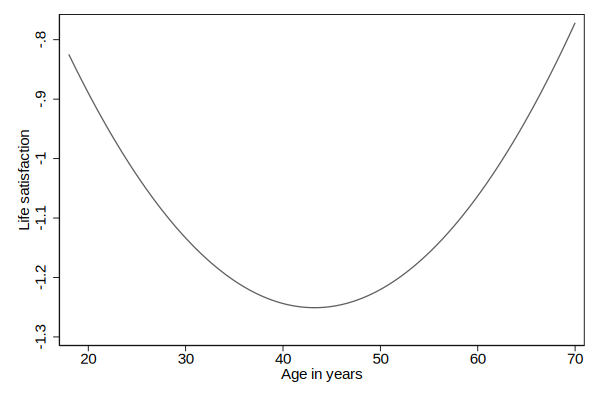

In [50]:
twoway function _b[age_at_signup] * x + _b[c.age_at_signup#c.age_at_signup] * x^2 ///
, range(18 70) xtitle(Age in years) ytitle(Life satisfaction)

Classic U-shape? Check.

## Robustness: fixed-effects filter (`xtfef`) regressions

Now we try something similar to the main spec, but using `xtfef` to deal with any unobserved inter-individual variability.

The `xtfef` command doesn't support factor variables, `estimates store` or `parmest`, so some faffing is involved. It also appears not to support postestimation with `test`.

First: set base levels with `char`.

In [51]:
/*
// from main spec, for reference: 

local userrhsvars ///
  lnhhinc b3.work b1.male#b0.anykids b4.mrg b1.adults age_at_signup c.age_at_signup#c.age_at_signup b5.health b7.home_nspd_go_region

local rhsvars ///
  `userrhsvars' ///
  b2010.response_year response_seq c.response_seq#c.response_seq ///
  weekly_count c.weekly_count#c.weekly_count
*/

char work[omit] 3
char male[omit] 1
char anykids[omit] 0
char mrg[omit] 4
char adults[omit] 1
char health[omit] 5
char home_nspd_go_region[omit] 7
char response_year[omit] 2010
char weekly_count[omit] 2

Next: generate the interactions that `xi` doesn't support.

In [52]:
capture drop agesq
capture drop rseqsq

gen agesq = age_at_signup * age_at_signup
gen rseqsq = response_seq * response_seq

In [53]:
capture drop malekids
capture drop femalenokids
capture drop femalekids

gen malekids = male & anykids
gen femalenokids = !male & !anykids
gen femalekids = !male & anykids

count if varsampleseq == 1
count if varsampleseq == 1 & !malekids & !femalenokids & !femalekids
count if varsampleseq == 1 & malekids
count if varsampleseq == 1 & femalenokids
count if varsampleseq == 1 & femalekids








  41,023

  14,398

  6,282

  14,721

  5,622


Now: run the models.

In [54]:
local rhsuserinvariants ///
  lnhhinc i.work malekids femalenokids femalekids i.mrg i.adults age_at_signup agesq i.health i.home_nspd_go_region

local rhsvariants ///
  i.response_year response_seq rseqsq ///
  i.weekly_count

foreach feeling in hpy rlx awk {
  foreach param in mean sd {
    
    capture drop z_`feeling'_wmsq
    gen z_`feeling'_wmsq = z_`feeling'_weekly_mean * z_`feeling'_weekly_mean
    
    local mean_controls = cond("`param'" == "sd", " z_`feeling'_weekly_mean z_`feeling'_wmsq", "")
    
    disp ""  // line break
    disp "LHS: z_`feeling'_weekly_`param'"
    xi: xtfef z_`feeling'_weekly_`param' if userweekseq == 1 & varsample, ///
      invariant(`rhsuserinvariants') varying(`rhsvariants'`mean_controls') ///
      i(user_id) t(response_monday)
  }
}




(1,490,459 missing values generated)

LHS: z_hpy_weekly_mean
i.work            _Iwork_1-8          (naturally coded; _Iwork_3 omitted)
i.mrg             _Imrg_1-5           (naturally coded; _Imrg_4 omitted)
i.adults          _Iadults_1-4        (naturally coded; _Iadults_1 omitted)
i.health          _Ihealth_1-5        (naturally coded; _Ihealth_5 omitted)
i.home_nspd_g~n   _Ihome_nspd_1-99    (naturally coded; _Ihome_nspd_7 omitted)
i.response_year   _Iresponse__2010-2016(naturally coded; _Iresponse__2010 omitte
> d)
i.weekly_count    _Iweekly_co_1-7     (naturally coded; _Iweekly_co_2 omitted)
note: _Iweekly_co_1 omitted because of collinearity

Fixed-Effects-Filter estimation             Number of obs      =    338447
Group variable: user_id                     Number of groups   =     41023

Time variable: response_m~y                 Obs per group: min =         1
                                                           avg =  8.250177
                                       

Handily, the results for happiness variability appear very much in line with those in the main spec.

## Robustness: N responses in M days, one row per user OLS regressions

As another robustness check, we try something simpler. Instead of looking at variability per user-week (based on any number of responses from 2 to 7), we calculate the standard deviation across each user's first N valid responses given within M days. That means we drop anyone who didn't provide at least N responses, and any responses past response number N.

This approach means our results can't be confounded by different response patterns, and we only count each user once. However, it may be that people who stick with the app for N+ valid responses, and can give N+ valid responses within M days, are different from others.

### Choose N and M

In [55]:
capture drop userseqmax
bysort user_id: egen userseqmax = max(userseq)

In [56]:
%head 25 user_id response_seq userseq userseqmax

,user_id,response_seq,userseq,userseqmax
1,33,24,1,7
2,33,25,2,7
3,33,31,3,7
4,33,34,4,7
5,33,37,5,7
6,33,38,6,7
7,33,39,7,7
8,43,18,1,182
9,43,21,2,182
10,43,23,3,182


How many users with at least N responses?

In [57]:
forvalues i = 2(2)30 {
  disp `i'
  count if userseq == 1 & userseqmax >= `i'
}


2
  46,047
4
  40,444
6
  36,586
8
  33,369
10
  30,778
12
  28,431
14
  26,378
16
  24,558
18
  22,924
20
  21,491
22
  20,150
24
  18,845
26
  17,706
28
  16,677
30
  15,719


We'll try N = 14 responses.

Next: how long did users take to contribute these responses? If they took a long time, changes in circumstances might make a substantial contribution to the variation we see.

In [58]:
capture drop resp_period_start
capture drop resp_period_end
capture drop resp_period_days

by user_id: egen resp_period_start = min(response_td) if userseqmax >= 14
by user_id: egen resp_period_end = max(response_td) if userseq <= 14
gen resp_period_days = resp_period_end - resp_period_start + 1





(128627 missing values generated)

(1330987 missing values generated)

(1,459,614 missing values generated)


In [59]:
forvalues i = 12(2)60 {
  disp `i'
  count if userseq == 1 & resp_period_days <= `i'
}


12
  0
14
  7,473
16
  15,204
18
  18,797
20
  20,757
22
  22,113
24
  23,047
26
  23,659
28
  24,108
30
  24,445
32
  24,731
34
  24,958
36
  25,134
38
  25,286
40
  25,415
42
  25,516
44
  25,606
46
  25,687
48
  25,745
50
  25,789
52
  25,840
54
  25,889
56
  25,927
58
  25,951
60
  25,980


Let's go for 28 days: that's on average a response at least every other day.

### Collapse the data

In [60]:
net install collapseandpreserve, from(https://raw.github.com/bquistorff/Stata-modules/master/c/) replace

checking collapseandpreserve consistency and verifying not already installed...
all files already exist and are up to date.


In [61]:
frame copy default rowperuser, replace
frame rowperuser {
  keep if resp_period_days <= 28
  
  #delimit ;
  collapseandpreserve 
    (mean) mean_hpy=feel_hpy mean_rlx=feel_rlx mean_awk=feel_awk
    (sd) sd_hpy=feel_hpy sd_rlx=feel_rlx sd_awk=feel_awk
    (first) lnhhinc male work age_at_signup anykids adults mrg health home_nspd_go_region response_td resp_period_days
  , by(user_id);
  
  #delimit cr
}


(note: frame rowperuser not found)

(1,491,394 observations deleted)


### Z-scores

In [62]:
frame rowperuser {
  foreach feeling in hpy rlx awk {
    foreach param in mean sd {
      capture drop z_`param'_`feeling'
      egen z_`param'_`feeling' = std(`param'_`feeling')
    }
  }
}

### Regressions

In [63]:
frame rowperuser {
  foreach feeling in hpy rlx awk {
    foreach param in mean sd {

      local mean_controls = cond("`param'" == "sd", "z_mean_`feeling' c.z_mean_`feeling'#c.z_mean_`feeling'", "")

      reg z_`param'_`feeling' `userrhsvars' `mean_controls' b14.resp_period_days, vce(hc3)

      test 0.male#0b.anykids = 0.male#1.anykids  // woman with kids vs woman without kids
      test 0.male#1.anykids = 1b.male#1.anykids  // man with kids vs woman with kids

      estimates store alt_reg_`feeling'_`param'
    }
  }
}



Linear regression                               Number of obs     =     22,365
                                                F(49, 22315)      =      28.80
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0650
                                                Root MSE          =     .96535

-------------------------------------------------------------------------------
              |             Robust HC3
   z_mean_hpy |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
--------------+----------------------------------------------------------------
      lnhhinc |   .0280771   .0097763     2.87   0.004     .0089148    .0472395
              |
         work |
        care  |   .0659216   .0521676     1.26   0.206    -.0363305    .1681736
         edu  |  -.0246496   .0249259    -0.99   0.323    -.0735061     .024207
         ret  |   .2645973   .1042438     2.54   0.

### Tables

In [64]:
%html
#delimit ;
foreach feeling in hpy rlx awk {;

  estout alt_reg_`feeling'_mean alt_reg_`feeling'_sd, 
    style(html) prehead("<hr /><h4>`feeling'</h4><table>") postfoot("</table>")
    cells((b(fmt(%20.3g)) ci(par fmt(%20.3g))))
    stats(N r2 r2_a F df_m df_r, 
      fmt(0  3    3 3    0    0) 
      labels("N" "R<sup>2</sup>" "Adjusted R<sup>2</sup>")
    )
    legend
    mlabels("<b>Mean</b>" "<b>Std dev</b>")
    collabels("<i>Coeff</i>" "<i>[95% CI]</i>")
    // nobaselevels
    drop(
      // nobaselevels drops base levels in interactions, so we resort to dropping them manually instead
      3.work 
      1.male#0.anykids
      4.mrg
      1.adults
      5.health
      7.home_nspd_go_region
      14.resp_period_days
    )

    refcat(
      1.work "<b>Employment status</b><br>Base: employed or self-employed"
      0.male#0.anykids "<b>Gender × children in household</b><br>Base: male, no children"
      1.mrg "<b>Marital status</b><br>Base: single"
      2.adults "<b>Adults in the household</b><br>Base: 1"
      age_at_signup "<b>Age at signup</b>"
      1.health "<b>Self-reported health</b><br>Base: excellent"
      1.home_nspd_go_region "<b>Home region</b><br>Base: London"
      2011.response_year "<b>Year (at first response)</b><br>Base: 2010"
      2.response_month "<b>Month (at first response)</b><br>Base: Jan"
      z_mean_hpy "<b>Mean happiness</b>"
      z_mean_rlx "<b>Mean relaxation</b>"
      z_mean_awk "<b>Mean wakefulness</b>"
      15.resp_period_days "<b>Days to reach 14 responses</b><br>Base: 14"
      _cons ""
    , nolabel)

    varlabels(
      1.work "Looking after family or home"
      2.work "In full-time education"
      5.work "Retired"
      6.work "Long-term sick or disabled"
      7.work "Unemployed and seeking work"
      8.work "Other"
      lnhhinc "Log of household income"
      male "Male"
      anykids "Children in household"
      0.male#0.anykids "Female, no children"
      0.male#1.anykids "Female, with children"
      1.male#1.anykids "Male, with children"
      1.mrg "Divorced"
      2.mrg "Married"
      3.mrg "Separated"
      5.mrg "Widowed"
      2.adults "2"
      3.adults "3"
      4.adults "4 or more"
      age_at_signup "Age"
      c.age_at_signup#c.age_at_signup "Age squared"
      1.health "Poor"
      2.health "Fair"
      3.health "Good"
      4.health "Very good"
      1.home_nspd_go_region "North East" // E12000001
      2.home_nspd_go_region  "North West"  // E12000002 
      3.home_nspd_go_region  "Yorkshire and The Humber"  // E12000003 
      4.home_nspd_go_region  "East Midlands"  // E12000004 
      5.home_nspd_go_region  "West Midlands"  // E12000005 
      6.home_nspd_go_region  "East of England"  // E12000006 
      8.home_nspd_go_region  "South East"  // E12000008 
      9.home_nspd_go_region  "South West"  // E12000009 
      10.home_nspd_go_region "Northern Ireland"  // N99999999  
      11.home_nspd_go_region "Scotland"  // S99999999  
      12.home_nspd_go_region "Wales"  // W99999999
      99.home_nspd_go_region "Unknown/non-UK"
      2011.response_year "2011"
      2012.response_year "2012"
      2013.response_year "2013"
      2014.response_year "2014"
      2015.response_year "2015"
      2016.response_year "2016"
      2.response_month "Feb"
      3.response_month "Mar"
      4.response_month "Apr"
      5.response_month "May"
      6.response_month "Jun"
      7.response_month "Jul"
      8.response_month "Aug"
      9.response_month "Sep"
      10.response_month "Oct"
      11.response_month "Nov"
      12.response_month "Dec"
      15.resp_period_days "15"
      16.resp_period_days "16"
      17.resp_period_days "17"
      18.resp_period_days "18"
      19.resp_period_days "19"
      20.resp_period_days "20"
      21.resp_period_days "21"
      22.resp_period_days "22"
      23.resp_period_days "23"
      24.resp_period_days "24"
      25.resp_period_days "25"
      26.resp_period_days "26"
      27.resp_period_days "27"
      28.resp_period_days "28"
      z_mean_hpy "Happiness"
      c.z_mean_hpy#c.z_mean_hpy "Happiness squared"
      z_mean_rlx "Relaxation"
      c.z_mean_rlx#c.z_mean_rlx "Relaxation squared"
      z_mean_awk "Wakefulness"
      c.z_mean_awk#c.z_mean_awk "Wakefulness squared"
      _cons "Constant"
    ); 
};
#delimit cr

,Mean,,Std dev,
,Coeff,[95% CI],Coeff,[95% CI]
Log of household income,.0281,"[.00891,.0472]",-.0446,"[-.063,-.0263]"
Employment statusBase: employed or self-employed,,,,
Looking after family or home,.0659,"[-.0363,.168]",-.0148,"[-.107,.0776]"
In full-time education,-.0246,"[-.0735,.0242]",-.182,"[-.23,-.134]"
Retired,.265,"[.0603,.469]",-.136,"[-.283,.0118]"
Long-term sick or disabled,-.0887,"[-.266,.0881]",.00817,"[-.139,.156]"
Unemployed and seeking work,-.115,"[-.2,-.0313]",-.0895,"[-.162,-.0165]"
Other,.0155,"[-.0837,.115]",-.0323,"[-.137,.0724]"
"Gender × children in householdBase: male, no children",,,,


## Activities

It's an interesting question how far variability in happiness responses is driven by variability in the activities people do.

How to quantify variability is not immediately obvious (note that one existing metric for categorical data, _unalikeability_, assumes only one category per occasion).

Here, we take the number of unique activities divided by the number of responses.

For example, take these response sequences:

```
A
Response 1: working
Response 2: working; in a meeting
Response 3: travelling; listening to music
Response 4: travelling

B
Response 1: working
Response 2: travelling
```

For both A and B our metric would be 1.

This takes account both of variety within response occasions (doing more than one thing at once) and across occasions.

So: the first step is to make a new variable for each activity indicating whether that activity was done at any point in each user-week.

In [65]:
foreach v of varlist do_* {
  disp "`v'"
  capture drop ever_`v'
  bysort user_id response_monday: egen ever_`v' = max(`v')
}


do_work
do_meet
do_travel
do_cook
do_chores
do_wait
do_shop
do_admin
do_child
do_pet
do_care
do_rest
do_sick
do_pray
do_wash
do_chat
do_love
do_eat
do_caffeine
do_booze
do_smoke
do_msg
do_net
do_tv
do_music
do_speech
do_read
do_theatre
do_museum
do_match
do_walk
do_sport
do_gardening
do_birdwatch
do_compgame
do_hunt
do_game
do_bet
do_art
do_sing
do_other
do_other2


Now we sum the total number of activities ever done during the week, and divide by the number of responses:

In [66]:
capture drop weekly_activity_count
egen weekly_activity_count = rowtotal(ever_do_*)

(bin=26, start=1, width=1)


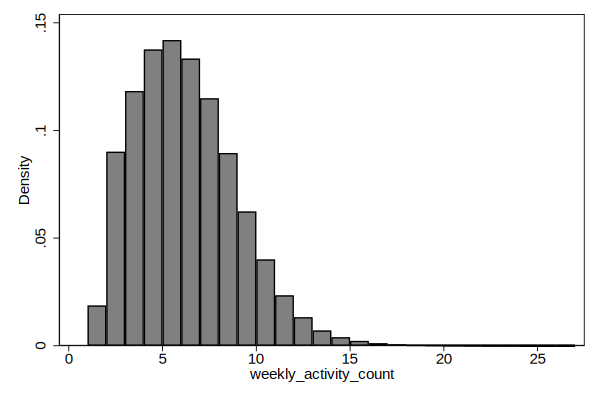

In [67]:
hist weekly_activity_count if varsample, width(1)

In [68]:
capture drop weekly_activity_ratio
gen weekly_activity_ratio = weekly_activity_count / weekly_count

Does this look right?

In [69]:
%head response_td response_monday weekly_count weekly_activity_count weekly_activity_ratio do_* ever_do_* if user_id == 290

,response_td,response_monday,weekly_count,weekly_activity_count,weekly_activity_ratio,do_work,do_meet,do_travel,do_cook,do_chores,do_wait,do_shop,do_admin,do_child,do_pet,do_care,do_rest,do_sick,do_pray,do_wash,do_chat,do_love,do_eat,do_caffeine,do_booze,do_smoke,do_msg,do_net,do_tv,do_music,do_speech,do_read,do_theatre,do_museum,do_match,do_walk,do_sport,do_gardening,do_birdwatch,do_compgame,do_hunt,do_game,do_bet,do_art,do_sing,do_other,do_other2,ever_do_work,ever_do_meet,ever_do_travel,ever_do_cook,ever_do_chores,ever_do_wait,ever_do_shop,ever_do_admin,ever_do_child,ever_do_pet,ever_do_care,ever_do_rest,ever_do_sick,ever_do_pray,ever_do_wash,ever_do_chat,ever_do_love,ever_do_eat,ever_do_caffeine,ever_do_booze,ever_do_smoke,ever_do_msg,ever_do_net,ever_do_tv,ever_do_music,ever_do_speech,ever_do_read,ever_do_theatre,ever_do_museum,ever_do_match,ever_do_walk,ever_do_sport,ever_do_gardening,ever_do_birdwatch,ever_do_compgame,ever_do_hunt,ever_do_game,ever_do_bet,ever_do_art,ever_do_sing,ever_do_other,ever_do_other2
11922,Sat 14 Aug 2010,Mon 09 Aug 2010,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11923,Sun 15 Aug 2010,Mon 09 Aug 2010,2,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11924,Sat 21 Aug 2010,Mon 16 Aug 2010,6,5,.8333333333333334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11925,Thu 19 Aug 2010,Mon 16 Aug 2010,6,5,.8333333333333334,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11926,Tue 17 Aug 2010,Mon 16 Aug 2010,6,5,.8333333333333334,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11927,Fri 20 Aug 2010,Mon 16 Aug 2010,6,5,.8333333333333334,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11928,Wed 18 Aug 2010,Mon 16 Aug 2010,6,5,.8333333333333334,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11929,Mon 16 Aug 2010,Mon 16 Aug 2010,6,5,.8333333333333334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11930,Fri 27 Aug 2010,Mon 23 Aug 2010,6,6,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11931,Mon 23 Aug 2010,Mon 23 Aug 2010,6,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Yes, it does. How's it distributed?

(bin=32, start=.14285714, width=.25)


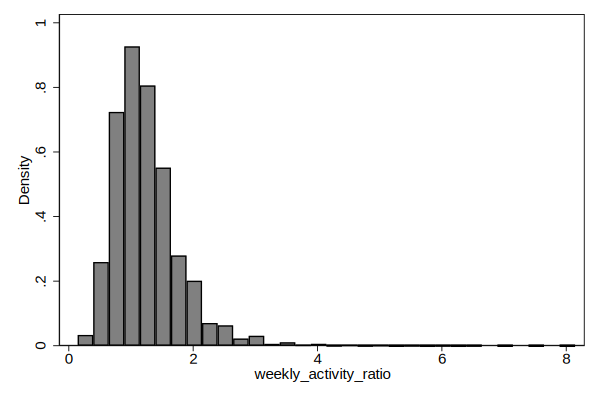

In [70]:
hist weekly_activity_ratio if varsample, width(.25)

And for plotting purposes, where exactly are the extremes?

In [71]:
centile weekly_activity_ratio if varsample, centile(0 1 99 100)


                                                       -- Binom. Interp. --
    Variable |       Obs  Percentile    Centile        [95% Conf. Interval]
-------------+-------------------------------------------------------------
weekly_act~o |   338,447          0    .1428571        .1428571    .1428571*
             |                    1          .4              .4          .4
             |                   99           3               3           3
             |                  100           8               8           8*

* Lower (upper) confidence limit held at minimum (maximum) of sample


In [72]:
summ weekly_activity_ratio if varsample


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
weekly_act~o |    338,447    1.232923    .5417357   .1428571          8


In [73]:
pwcorr weekly_activity_ratio hpy_weekly_mean hpy_weekly_sd, sig


             | weekly~o hpy_~ean hpy_we~d
-------------+---------------------------
weekly_act~o |   1.0000 
             |
             |
hpy_week~ean |   0.0924   1.0000 
             |   0.0000
             |
hpy_weekly~d |  -0.0063  -0.2879   1.0000 
             |   0.0000   0.0000
             |


### Regress happiness mean/SD on variability

In [74]:
%set graph_width 600

In [75]:
%set graph_height 400




Linear regression                               Number of obs     =    338,447
                                                F(50, 41022)      =      28.09
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0687
                                                Root MSE          =     .96512

                            (Std. Err. adjusted for 41,023 clusters in user_id)
-------------------------------------------------------------------------------
              |               Robust
z_hpy_weekl~n |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
--------------+----------------------------------------------------------------
weekly_acti~o |    .442819   .0295673    14.98   0.000     .3848664    .5007717
              |
           c. |
weekly_acti~o#|
           c. |
weekly_acti~o |  -.0581298   .0071744    -8.10   0.000    -.0721919   -.0440678
              |
    

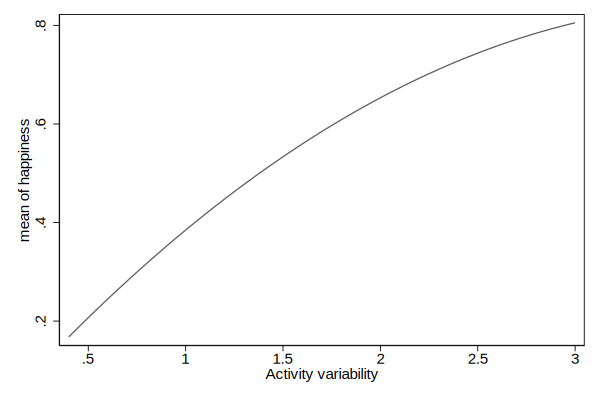


Linear regression                               Number of obs     =    338,447
                                                F(52, 41022)      =     221.78
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1567
                                                Root MSE          =     .91839

                            (Std. Err. adjusted for 41,023 clusters in user_id)
-------------------------------------------------------------------------------
              |               Robust
z_hpy_weekl~d |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
--------------+----------------------------------------------------------------
weekly_acti~o |   .1548563   .0201954     7.67   0.000     .1152728    .1944397
              |
           c. |
weekly_acti~o#|
           c. |
weekly_acti~o |  -.0209311   .0057238    -3.66   0.000    -.0321499   -.0097124
              |
      

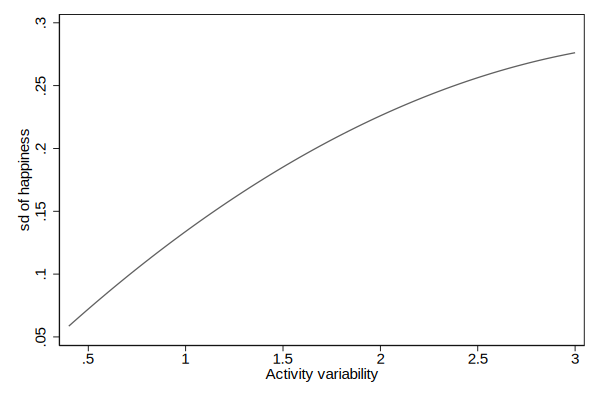

In [76]:
local feeling hpy
foreach param in mean sd {
  
  local mean_controls = cond("`param'" == "mean", "", ///
    "z_`feeling'_weekly_mean c.z_`feeling'_weekly_mean#c.z_`feeling'_weekly_mean")
  
  reg z_`feeling'_weekly_`param' ///
    weekly_activity_ratio c.weekly_activity_ratio#c.weekly_activity_ratio ///
    `rhsvars' `mean_controls' ///
    if varsample, vce(cluster user_id)

  test 0.male#0b.anykids = 0.male#1.anykids  // woman with kids vs woman without kids
  test 0.male#1.anykids = 1b.male#1.anykids  // man with kids vs woman with kids
  
  estimates store reg_`feeling'_vrbty_`param'
  
  twoway function _b[weekly_activity_ratio] * x + _b[c.weekly_activity_ratio#c.weekly_activity_ratio] * x^2 ///
  , range(.4 3) xtitle(Activity variability) ytitle(`param' of happiness)
}

In [77]:
%html

#delimit ;
estout reg_hpy_mean reg_hpy_vrbty_mean reg_hpy_sd reg_hpy_vrbty_sd, 
  style(html) prehead("<h4>`feeling'</h4><table>") postfoot("</table><hr>")
  cells((b(fmt(%20.3g)) ci(par fmt(%20.3g))))
  stats(N N_clust r2 r2_a F df_m df_r, 
    fmt(0       0  3    3 3    0    0) 
    labels("N (user-weeks)" "Users" "R<sup>2</sup>" "Adjusted R<sup>2</sup>")
  )
  legend
  mlabels("<b>Mean</b>" "<b>Mean</b>" "<b>Std dev</b>" "<b>Std dev</b>")
  collabels("<i>Coeff</i>" "<i>[95% CI]</i>")
  drop(
    // nobaselevels drops base levels in interactions, so we resort to dropping them manually instead
    3.work 
    1.male#0.anykids
    4.mrg
    1.adults
    5.health
    7.home_nspd_go_region
    2010.response_year
    2.weekly_count
  )
  refcat(
    1.work "<b>Employment status</b><br>Base: employed or self-employed"
    0.male#0.anykids "<b>Gender × children in household</b><br>Base: male, no children"
    1.mrg "<b>Marital status</b><br>Base: single"
    2.adults "<b>Adults in the household</b><br>Base: 1"
    age_at_signup "<b>Age at signup</b>"
    1.health "<b>Self-reported health</b><br>Base: excellent"
    1.home_nspd_go_region "<b>Home region</b><br>Base: London"
    2011.response_year "<b>Year (at first response of week)</b><br>Base: 2010"
    response_seq "<b>Prior responses</b>"
    3.weekly_count "<b>Week's responses</b><br>Base: 2"
    z_hpy_weekly_mean "<b>Mean happiness</b>"
    z_rlx_weekly_mean "<b>Mean relaxation</b>"
    z_awk_weekly_mean "<b>Mean wakefulness</b>"
    _cons ""
  , nolabel)
  varlabels(
    weekly_activity_ratio "Activity variability"
    c.weekly_activity_ratio#c.weekly_activity_ratio "Activity variability squared"
    1.work "Looking after family or home"
    2.work "In full-time education"
    5.work "Retired"
    6.work "Long-term sick or disabled"
    7.work "Unemployed and seeking work"
    8.work "Other"
    lnhhinc "Log of household income"
    0.male#0.anykids "Female, no children"
    0.male#1.anykids "Female, with children"
    1.male#1.anykids "Male, with children"
    1.mrg "Divorced"
    2.mrg "Married"
    3.mrg "Separated"
    5.mrg "Widowed"
    2.adults "2"
    3.adults "3"
    4.adults "4 or more"
    age_at_signup "Age"
    c.age_at_signup#c.age_at_signup "Age squared"
    1.health "Poor"
    2.health "Fair"
    3.health "Good"
    4.health "Very good"
    1.home_nspd_go_region "North East" // E12000001
    2.home_nspd_go_region  "North West"  // E12000002 
    3.home_nspd_go_region  "Yorkshire and The Humber"  // E12000003 
    4.home_nspd_go_region  "East Midlands"  // E12000004 
    5.home_nspd_go_region  "West Midlands"  // E12000005 
    6.home_nspd_go_region  "East of England"  // E12000006 
    8.home_nspd_go_region  "South East"  // E12000008 
    9.home_nspd_go_region  "South West"  // E12000009 
    10.home_nspd_go_region "Northern Ireland"  // N99999999  
    11.home_nspd_go_region "Scotland"  // S99999999  
    12.home_nspd_go_region "Wales"  // W99999999
    99.home_nspd_go_region "Unknown/non-UK"
    2011.response_year "2011"
    2012.response_year "2012"
    2013.response_year "2013"
    2014.response_year "2014"
    2015.response_year "2015"
    2016.response_year "2016"
    response_seq "Count"
    c.response_seq#c.response_seq "Count squared"
    3.weekly_count "3"
    4.weekly_count "4"
    5.weekly_count "5"
    6.weekly_count "6"
    7.weekly_count "7"
    z_`feeling'_weekly_mean "Standardized mean"
    c.z_`feeling'_weekly_mean#c.z_`feeling'_weekly_mean "Standardized mean squared"
    _cons "Constant"
  );
#delimit cr

,Mean,,Mean,,Std dev,,Std dev,
,Coeff,[95% CI],Coeff,[95% CI],Coeff,[95% CI],Coeff,[95% CI]
Log of household income,.0462,"[.0181,.0742]",.0476,"[.0206,.0747]",-.0208,"[-.0359,-.00579]",-.02,"[-.035,-.005]"
Employment statusBase: employed or self-employed,,,,,,,,
Looking after family or home,.0507,"[-.0741,.176]",.0341,"[-.0922,.16]",-.065,"[-.139,.00849]",-.0706,"[-.145,.00404]"
In full-time education,.0166,"[-.0373,.0705]",.00881,"[-.0444,.062]",-.0963,"[-.135,-.0573]",-.0989,"[-.138,-.0597]"
Retired,.0122,"[-.385,.41]",.0125,"[-.357,.382]",-.16,"[-.276,-.0435]",-.16,"[-.273,-.0473]"
Long-term sick or disabled,-.214,"[-.365,-.0626]",-.23,"[-.378,-.0809]",-.11,"[-.212,-.00736]",-.117,"[-.218,-.0154]"
Unemployed and seeking work,-.0978,"[-.18,-.0154]",-.109,"[-.191,-.026]",-.062,"[-.119,-.00483]",-.0664,"[-.124,-.00927]"
Other,-.0424,"[-.15,.0652]",-.0686,"[-.178,.0409]",-.0756,"[-.151,-.000327]",-.0849,"[-.16,-.0102]"
"Gender × children in householdBase: male, no children",,,,,,,,


So: activity variability matters and is overall positive for both mean and SD of happiness. **But** it makes very little difference to any of the other effects we find.

### Regress activity variability on demographics



(1490459 missing values generated)


Linear regression                               Number of obs     =    338,447
                                                F(48, 41022)      =      79.94
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0857
                                                Root MSE          =     .95626

                            (Std. Err. adjusted for 41,023 clusters in user_id)
-------------------------------------------------------------------------------
              |               Robust
z_weekly_ac~o |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
--------------+----------------------------------------------------------------
      lnhhinc |  -.0175539   .0107615    -1.63   0.103    -.0386466    .0035388
              |
         work |
        care  |   .0935663   .0429103     2.18   0.029      .009461    .1776715
         edu  | 

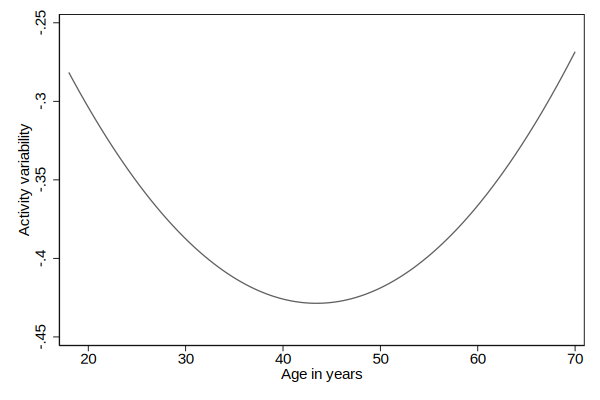

In [78]:
capture drop z_weekly_activity_ratio
egen z_weekly_activity_ratio = std(weekly_activity_ratio) if varsample

reg z_weekly_activity_ratio `rhsvars' if varsample, vce(cluster user_id)

test 0.male#0b.anykids = 0.male#1.anykids  // woman with kids vs woman without kids
test 0.male#1.anykids = 1b.male#1.anykids  // man with kids vs woman with kids

twoway function _b[age_at_signup] * x + _b[c.age_at_signup#c.age_at_signup] * x^2 ///
, range(18 70) xtitle(Age in years) ytitle(Activity variability)

In [79]:
%html

#delimit ;
estout, 
  style(html) prehead("<h4>`feeling'</h4><table>") postfoot("</table>")
  cells((b(fmt(%20.3g)) ci(par fmt(%20.3g))))
  stats(N N_clust r2 r2_a F df_m df_r, 
    fmt(0       0  3    3 3    0    0) 
    labels("N (user-weeks)" "Users" "R<sup>2</sup>" "Adjusted R<sup>2</sup>")
  )
  legend
  mlabels("<b>Activity variability</b>")
  collabels("<i>Coeff</i>" "<i>[95% CI]</i>")
  drop(
    // nobaselevels drops base levels in interactions, so we resort to dropping them manually instead
    3.work 
    1.male#0.anykids
    4.mrg
    1.adults
    5.health
    7.home_nspd_go_region
    2010.response_year
    2.weekly_count
  )
  refcat(
    1.work "<b>Employment status</b><br>Base: employed or self-employed"
    0.male#0.anykids "<b>Gender × children in household</b><br>Base: male, no children"
    1.mrg "<b>Marital status</b><br>Base: single"
    2.adults "<b>Adults in the household</b><br>Base: 1"
    age_at_signup "<b>Age at signup</b>"
    1.health "<b>Self-reported health</b><br>Base: excellent"
    1.home_nspd_go_region "<b>Home region</b><br>Base: London"
    2011.response_year "<b>Year (at first response of week)</b><br>Base: 2010"
    response_seq "<b>Prior responses</b>"
    3.weekly_count "<b>Week's responses</b><br>Base: 2"
    z_hpy_weekly_mean "<b>Mean happiness</b>"
    z_rlx_weekly_mean "<b>Mean relaxation</b>"
    z_awk_weekly_mean "<b>Mean wakefulness</b>"
    _cons ""
  , nolabel)
  varlabels(
    weekly_activity_ratio "Activity variability"
    c.weekly_activity_ratio#c.weekly_activity_ratio "Activity variability squared"
    1.work "Looking after family or home"
    2.work "In full-time education"
    5.work "Retired"
    6.work "Long-term sick or disabled"
    7.work "Unemployed and seeking work"
    8.work "Other"
    lnhhinc "Log of household income"
    0.male#0.anykids "Female, no children"
    0.male#1.anykids "Female, with children"
    1.male#1.anykids "Male, with children"
    1.mrg "Divorced"
    2.mrg "Married"
    3.mrg "Separated"
    5.mrg "Widowed"
    2.adults "2"
    3.adults "3"
    4.adults "4 or more"
    age_at_signup "Age"
    c.age_at_signup#c.age_at_signup "Age squared"
    1.health "Poor"
    2.health "Fair"
    3.health "Good"
    4.health "Very good"
    1.home_nspd_go_region "North East" // E12000001
    2.home_nspd_go_region  "North West"  // E12000002 
    3.home_nspd_go_region  "Yorkshire and The Humber"  // E12000003 
    4.home_nspd_go_region  "East Midlands"  // E12000004 
    5.home_nspd_go_region  "West Midlands"  // E12000005 
    6.home_nspd_go_region  "East of England"  // E12000006 
    8.home_nspd_go_region  "South East"  // E12000008 
    9.home_nspd_go_region  "South West"  // E12000009 
    10.home_nspd_go_region "Northern Ireland"  // N99999999  
    11.home_nspd_go_region "Scotland"  // S99999999  
    12.home_nspd_go_region "Wales"  // W99999999
    99.home_nspd_go_region "Unknown/non-UK"
    2011.response_year "2011"
    2012.response_year "2012"
    2013.response_year "2013"
    2014.response_year "2014"
    2015.response_year "2015"
    2016.response_year "2016"
    response_seq "Count"
    c.response_seq#c.response_seq "Count squared"
    3.weekly_count "3"
    4.weekly_count "4"
    5.weekly_count "5"
    6.weekly_count "6"
    7.weekly_count "7"
    z_`feeling'_weekly_mean "Standardized mean"
    c.z_`feeling'_weekly_mean#c.z_`feeling'_weekly_mean "Standardized mean squared"
    _cons "Constant"
  );
#delimit cr

,Activity variability,
,Coeff,[95% CI]
Log of household income,-.0176,"[-.0386,.00354]"
Employment statusBase: employed or self-employed,,
Looking after family or home,.0936,"[.00946,.178]"
In full-time education,.0474,"[.00384,.0909]"
Retired,.0322,"[-.264,.328]"
Long-term sick or disabled,.0923,"[-.0216,.206]"
Unemployed and seeking work,.0527,"[-.0153,.121]"
Other,.171,"[.0658,.277]"
"Gender × children in householdBase: male, no children",,


Interestingly, activity variability is higher for women than men but is not affected by having kids.

## Descriptives

### Person-level

In [80]:
capture label drop go_region_human
label define go_region_human 1 "North East" 2 "North West" 3 "Yorkshire and The Humber" 4 "East Midlands" ///
  5 "West Midlands" 6 "East of England" 7 "London" 8 "South East" 9 "South West" ///
  10 "Northern Ireland" 11 "Scotland" 12 "Wales" 99 "Non-UK or unknown"
label value home_nspd_go_region go_region_human

capture label drop health
label define health 5 "Excellent" 4 "Very good" 3 "Good" 2 "Fair" 1 "Poor"
label value health health

capture label drop people
label define people 0 "None" 1 "1" 2 "2" 3 "3" 4 "4+"
label value adults people
label value kids people

capture label drop incomelabels
label define incomelabels 4000 "Under £8,000" 10000 "£8,000 -- £11,999" 14000 "£12,000 -- £15,999" ///
  18000 "£16,000 -- £19,999" 22000 "£20,000 -- £23,999" 28000 "£24,000 -- £31,999" 36000 "£32,000 -- £39,999" ///
  48000 "£40,000 -- £55,999" 64000 "£56,000 -- £71,999" 84000 "£72,000 -- £95,999" 108000 "£96,000 or more"
label values hhinc incomelabels

In [81]:
summ age_at_signup lnhhinc if varsampleseq == 1


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
age_at_sig~p |     41,023    33.02323    10.03949         18         83
     lnhhinc |     41,023     10.5032    .8784816   8.294049   11.58989


(bin=33, start=18, width=2)


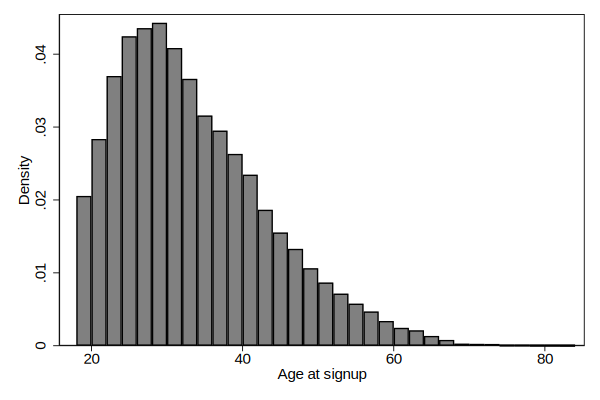

In [82]:
hist age_at_signup if varsampleseq == 1, width(2) xtitle("Age at signup")

In [83]:
fre male mrg work hhinc health adults kids home_nspd_go_region if varsampleseq == 1, nowrap nomissing


male
-----------------------------------------
       |      Freq.    Percent       Cum.
-------+---------------------------------
 0     |      20343      49.59      49.59
 1     |      20680      50.41     100.00
 Total |      41023     100.00           
-----------------------------------------

mrg
-----------------------------------------
       |      Freq.    Percent       Cum.
-------+---------------------------------
 1 div |       2164       5.28       5.28
 2 mrd |      12910      31.47      36.75
 3 sep |       1130       2.75      39.50
 4 sgl |      24651      60.09      99.59
 5 wid |        168       0.41     100.00
 Total |      41023     100.00           
-----------------------------------------

work
-------------------------------------------
         |      Freq.    Percent       Cum.
---------+---------------------------------
 1 care  |        802       1.96       1.96
 2 edu   |       5384      13.12      15.08
 3 emp   |      32094      78.23      93.31
 5 re

### Response-level

In [84]:
summ hpy_weekly_mean rlx_weekly_mean awk_weekly_mean if varsample


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
hpy_week~ean |    338,447    65.62207    16.47093          0        100
rlx_week~ean |    338,447    63.24911    16.96644          0        100
awk_week~ean |    338,447    61.61914    17.18475          0        100


In [85]:
summ hpy_weekly_sd rlx_weekly_sd awk_weekly_sd if varsample


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
hpy_weekly~d |    338,447    12.80785    9.427329          0   70.71068
rlx_weekly~d |    338,447    14.77627    10.10816          0   70.71068
awk_weekly~d |    338,447    14.84953    9.866982          0   70.71068


In [86]:
summ hpy_weekly_skew rlx_weekly_skew awk_weekly_skew if varsample


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
hpy_weekly~w |    285,947    -.077958    .2991165   -.801799   .8017888
rlx_weekly~w |    286,329   -.0751679    .3091364   -.801799   .8017888
awk_weekly~w |    285,810   -.0850345     .307521  -.8017837    .801799


#### Activities

Users can report doing any number of activities simultaneously.

In [87]:
count if varsample
local n = r(N)

foreach v of varlist do_* {
  quietly count if varsample & `v'
  local nv = r(N)
  local frac = round((r(N) / `n') * 100, 0.01)
  disp "`v'" _column(15) %7.0fc `nv' _column(25) %5.2f `frac' "%"
}


  338,447


do_work       104,791   30.96%
do_meet        12,370    3.65%
do_travel      31,520    9.31%
do_cook        13,781    4.07%
do_chores      15,239    4.50%
do_wait         8,988    2.66%
do_shop         8,567    2.53%
do_admin       14,803    4.37%
do_child       12,751    3.77%
do_pet          5,981    1.77%
do_care         1,950    0.58%
do_rest        28,861    8.53%
do_sick         5,336    1.58%
do_pray         1,114    0.33%
do_wash        10,686    3.16%
do_chat        40,537   11.98%
do_love         1,595    0.47%
do_eat         31,280    9.24%
do_caffeine    20,085    5.93%
do_booze       12,263    3.62%
do_smoke        4,424    1.31%
do_msg         21,602    6.38%
do_net         18,792    5.55%
do_tv          54,093   15.98%
do_music       19,189    5.67%
do_speech       6,319    1.87%
do_read        10,450    3.09%
do_theatre        765    0.23%
do_museum         555    0.16%
do_match        1,132    0.33%
do_walk         4,558    1.35%
do_sport        4,543    1